In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
import math

## Logistic Regression 


### Images

For this problem we'll use some simple images - a text classfication dataset that is a common ML toy dataset. Up until now we've only used text and numbers for data, how do we deal with images?

We can think of an image as a matrix of pixels. If you ever looked at your TV up extremely close as a kid, you've seen this. Each image here is a 28 by 28 pixel grid, each point on that grid is one pixel that can be somewhere on the black to white scale, which is represented by 0 to 255. So our overall dataset is ~70000 images, each one being a 28 x 28 (784 pixel) x 1 matrix. The only thing making it an image instead of a big table of numbers is how we interpret it when reading the data - if we don't know it is an image, we'd look at it as a bunch of integers; if we know to interpret it as an image, we can use those integers to draw what we were looking for!

If you have a 1080p TV or computer monitor the same logic applies: The screen is a 1920 x 1080 pixel grid, but here each pixel can be multiple colors (there are different color encodings, but the idea is the same) - so instead of each pixel on the grid having a depth of 1 (like our BW digits), each pixel has a depth of 3 - one for each of red, green, and blue, all on a 0 to 255 scale. This allows each pixel to have a position, and a color made up of a combo of those 3 values, giving us a pretty picture. If we were encoding a video, we'd have a series of these images in sequence - with 24, 30, 60 or however many frames per second. 

In [2]:
#Load Data
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


#### Image Data

Our images are currently stored as pixels. Each image is 28 x 28 pixels, so that is 784 total pixels. Each individual pixel is a value on a 255 pt scale - greyscale in this case. 

Our labels are just the numbers, if we look at a few, each is just a bunch-o-pixels. 

In [3]:
X.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Images as Arrays

The above visualization is one of those list of pixels if we picture it. There are 28 x 28 pixels in a 2D grid, and each of those pixels is some degree of "colored". It may be easier to see with a more elaborate image:

![Image Array](images/image_array.jpeg "Image Array" )

All of the "outside" pixels are 0 - black (ours are flipped - black text). Each part of the number has a higher number based on lightness. Our overall image is represented by a 28 x 28 x 1 array - width, height, and "depth" or "color depth", we only have one color (black) so the depth is 1.  This image is pretty low definition, so it is not super clear. The images on our monitors are the same, just with higher definition. We'll look at more elaborate images later, they are stored in the same way, except for color images we have 3 (usually) layers for depth. 

![RGB Image](images/rgb_image_array.png "RGB Image" )

A color image like this is a similar array as ours, but larger. If the image was 100 x 100 pixels, the array would be 100 x 100 x 3 (1 depth count per color) - this is also something called a tensor, which will be meaningful later. This is why we can do fun stuff with images like facial recognition - images are just big 'ol arrays. This is also why when we start dealing with high definition images or videos, things become MUCH slower; the amount of data in image data grows rapidly the better our images are. 

We can look at an image, there's a couple of steps to make it "image-y":
<ul>
<li>Take a row of data from the dataframe. 
<li>Make it into an array - 28 x 28. 
<li>Use mathplotlib to show the array of integers interpreted as an image.
</ul>

In [4]:
#Look at an image
def showDigit(digit, label, size=28):
    some_digit = digit
    #turn array into the correct shape
    some_digit_image = np.array(some_digit).reshape(size, size)
    #imshow displays an array like an image
    plt.imshow(some_digit_image, cmap=mpl.cm.binary)
    plt.title(label)
    plt.axis("off")
    plt.show()

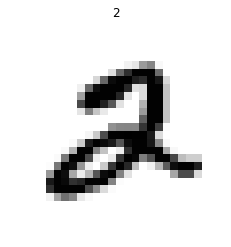

In [5]:
#The weird index is because it is a 2D array. We are basically grabing from the "start of 5" to the "start of 6"(non-inclusive)
showDigit(X[5:6], y[5])

In [6]:
#Display multiple digits
def showDigits(digits, labels, indexes, size=28):
    #Make a grid that is the right size
    pics = len(indexes)
    cols = 6
    rows = math.ceil(pics/cols)
    fig, axes = plt.subplots(rows, cols, figsize=(14,6))
    plt.axis("off")

    #loop through the list of indexes, grab images and labels, plot in the "next" spot. 
    for i in range(0, pics):
        n = indexes[i]
        some_digit = digits[n:n+1]
        some_digit_image = np.array(some_digit).reshape(size, size)
        ax = axes[i//cols, i%cols]
        ax.axis("off")
        ax.imshow(some_digit_image, cmap=mpl.cm.binary)
        ax.set_title('Ind: {} - Lbl: {}'.format(indexes[i], labels[n]))
    plt.tight_layout()
    plt.axis("off")
    plt.show()

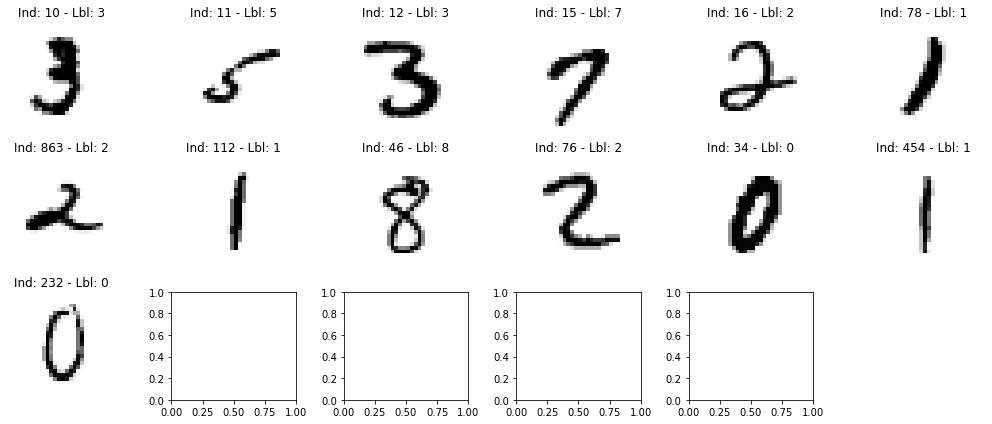

In [7]:
showDigits(X, y, [10,11,12,15,16,78,863,112,46,76,34,454,232])

### Exercise 1 - Load Digits Data. 

This dataset is one we can use as an exercise as we go through. It is a smaller version of the images that we are using. Most things translate pretty directly from the example. 

For now:
<ul>
<li>Load the data like we did with mnist. 
<li>Picture a digit, then a grid of digits. 
</ul>

A solved example is below. 

In [21]:
#EXERCISE
#Load Data
from sklearn.datasets import load_digits
digits = load_digits()
X, y = digits["data"], digits["target"]
print(X.shape)
print(y.shape)

(1797, 64)
(1797,)


ValueError: cannot reshape array of size 64 into shape (28,28)

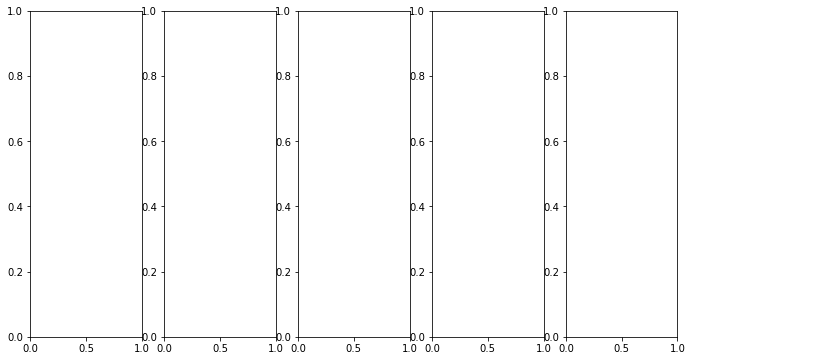

In [23]:
showDigits(X, y, [10,11,12,15,16,78])

### Softmax, One v All, One v One, and Multiple Classifications

Logistic regression separated two classes, predictions are either labeled as a 1 or a 0. In reality, we often want to predict more than just yes/no questions. For example, if we are doing facial recognition we likely don't want to settle for saying "yup, that is a person", we want to be able to determine who that person is. 

When we looked at decision trees, they were capable of doing multiple classifications directly, no adjustments needed. Linear classifiers are different though, they only separate between two classes, so we need a different approach. 

#### One vs Rest

One way to train a multiple classifier is to create a series of binary clasifiers, one for each outcome class vs "the rest". This is the default in sklearn's logistic regression. The end result is one classifier for each class. 

For our example: 1 vs not 1, 2 vs not 2, etc...

#### One vs One

Another method is to create a separate classifier for every combination of outcomes. This isn't implimented in sklearn's logistic regression but there is a class OneVsOneClassifier that allows you to plug in any classifier and the 1 vs 1 algorithm will be applied. 

For our example: 1 vs 2, 1 vs 3, 1 vs 4... 4 vs 5, 4 vs 6....

#### Softmax

For logistic regression, we make these classifications using something called Softmax Regression, or Multinomial Logistic Regression. The idea behind this is pretty simple, we just calculate a score for each class and the highest score is the prediction. 

Softmax will get a bit of a deeper look when we get to neural networks, for now it is more or less a multi-way version of the sigmoid function that we are used to seeing in classfications. Rather than splitting an individual prediction into two possibilites like the sigmoid, the softmax breaks out an individual probability for each of the possible output classes. 

So if we are predicting between 3 classes - A, B, and C, a model that is predicting B with pretty high confidence might produce an output like:
<ul>
<li> A - .228
<li> B - .619
<li> C - .153
</ul>

If the true answer is B, we'd have a real distribution that looks like:
<ul>
<li> A - 0
<li> B - 1
<li> C - 0
</ul>
I.e. the probability of it being B is 100%, since that's the true value; the probability of A or C is 0, because it isn't either of those. 

### Cross Entropy

Cross entropy is a very common cost function used when doing multiple classifications. 

The cross entropy loss function compares the real distribution to the expected one, and generates a metric for loss (like any other loss function). It will compare the predictions produced by the softmax to the true value and then calculate the loss. If we take the example from above, the cross entropy can be calculated with the formula:

![Cross Entropy](images/cross_ent.png "Cross Entropy" )

Resulting in an actual calculation of:

H = - (0.0*ln(0.228) + 1.0*ln(0.619) + 0.0*ln(0.153)) = 0.479

The gradient descent uses this amount of loss as we'd expect it to, and the training process just keeps repeating until we converge on a minimum amount of loss or run out of iterations to try. There is an expanded explaination here: https://stackoverflow.com/questions/41990250/what-is-cross-entropy/41990932#41990932 

We will spend more time on the details of loss stuff in neural networks. 

### Multiple Classifier

Now, we can try to evaluate the two methods against each other for our data while attempting to labels the digits from 0 to 9. 

#### Solver
One of the hyperparameters in the logistic regression call is the solver. This defines the method that the algorithm uses to do the gradient descent. The short answer is that it isn't something that we need to worry about too much unless we are looking for optimizing speed with large datasets. The slightly less short answer is that lbfgs (the default) is probably OK for most cases and either liblinear or saga (large datasets) if we want to feature select using L1 regularization. In any case, don't obsess over this. The documentation provides a little table for selecting an appropriate solver:

![Logistic Regression Solvers](images/log_reg_solvers.png "Logistic Regression Solvers" )

In [24]:
#Classify the digits

# This currently takes the first 10000 images, change commenting to take all
# It may take a long time with all data, especially if there is lots of grid searching and CV
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train, X_test, y_train, y_test = train_test_split(X[:10000], y[:10000], test_size=0.3)

# Scale inputs in a pipe
scaler = MinMaxScaler()
estimator = LogisticRegression(n_jobs=-1, solver="saga", max_iter=10000)
pipe = Pipeline(steps=[("scaler", scaler), ("log", estimator)])

# Try different classifications for the multiple classes
params = {'log__multi_class':["ovr","multinomial"]}

clf = GridSearchCV(pipe, param_grid=params, cv=3, n_jobs=-1) 
clf.fit(X_train, y_train.ravel())
best = clf.best_estimator_
train_preds = best.predict(X_train)
print(best)
print(best.score(X_test, y_test))


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('log',
                 LogisticRegression(max_iter=10000, multi_class='multinomial',
                                    n_jobs=-1, solver='saga'))])
0.9648148148148148


### Exercise 2 - Make Models 

Take the digits data and make a model. Score it on test data. 

In [10]:
#EXERCISE
#Model with the digit data. 

### Classification Results

We can look at the results of our classification, the confusion matrix still works, it is just a little more complex with multiple classes. 

<AxesSubplot:>

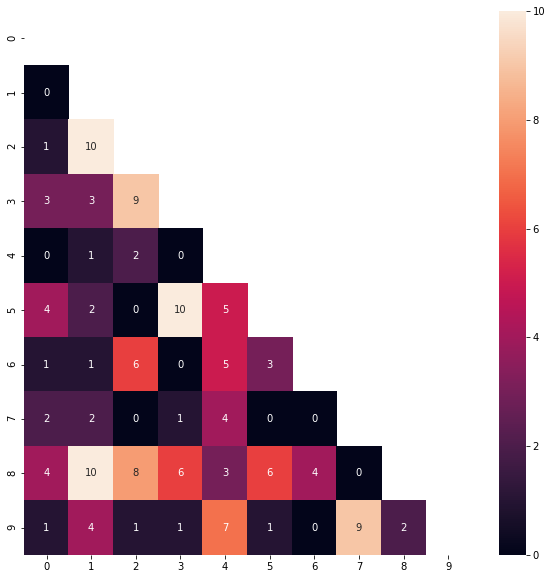

In [11]:
#Create Confusion Matrix
from sklearn.metrics import confusion_matrix
plt.rcParams["figure.figsize"] = (10,10)

preds = best.predict(X_test)

corr = confusion_matrix(y_test,preds)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, mask=mask)

We can take a look at the heatmap to see how often we are wrong with different combinations of digits. For example, 7 and 9 having frequent errors isn't every surprising. 

The confustion matrix is a 2D array of counts of errors. We can extract the values for each number to look at the differences in performance for each digit. 

In [12]:
print(corr)

# Grab each row, which represents one digit, and add up the errors. 
# Be sure to exclude the "spine" of counts. 
ers = []
for i in range(len(corr)):
    num = corr[i]
    #print(num)
    before = num[:i]
    after = num[i+1:]
    #print(before, after)
    tmp_err = np.sum(before) + np.sum(after)
    ers.append(tmp_err)
print(ers)

[[307   0   1   0   0   5   3   1   4   0]
 [  0 340   1   2   0   1   0   0   7   0]
 [  1  10 259   5   5   4   4   6  13   5]
 [  3   3   9 251   0   8   0   2   7   5]
 [  0   1   2   0 241   0   5   3   3  13]
 [  4   2   0  10   5 223   4   2   7   3]
 [  1   1   6   0   5   3 282   0   3   1]
 [  2   2   0   1   4   0   0 303   1  16]
 [  4  10   8   6   3   6   4   0 219   7]
 [  1   4   1   1   7   1   0   9   2 276]]
[14, 11, 53, 37, 27, 37, 20, 26, 48, 26]


<AxesSubplot:>

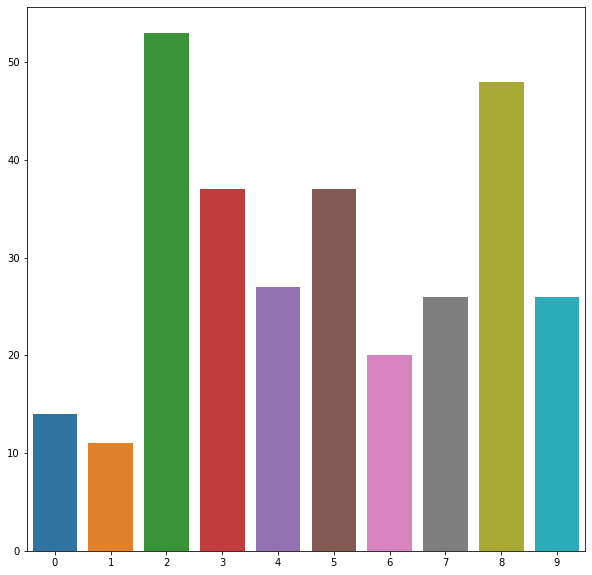

In [13]:
#Errors Per Number
sns.barplot(y=ers, x=[0,1,2,3,4,5,6,7,8,9])

### Error Distribution

As we might expect the errors are skewed towards numbers that look similar, like a 6 and an 8. There's no intuitive way to know what we can do with our modeling to improve this - maybe some different algorithm gives better results, or a different set of HPs that we can find with a grid search. 

Most likely we'll need to do some processing of the data to understand them a little better as images rather than just tables of pixels. Image processing is something we'll look into a bit more later on in the course. 

### Exercise 3 - Examine Results 

Take the digits model results and examine. 

Try:
<ul>
<li>Heatmap.
<li>Errors per digit. 
</ul>

In [14]:
#EXERCISE
#Plot results of model

## Example Solution - Digits

Try with a slightly more simple example - an 8 x 8 version of the same thing.

In [25]:
#Load Data
from sklearn.datasets import load_digits
digits = load_digits()
Xd, yd = digits["data"], digits["target"]
print(Xd.shape)
print(yd.shape)

(1797, 64)
(1797,)


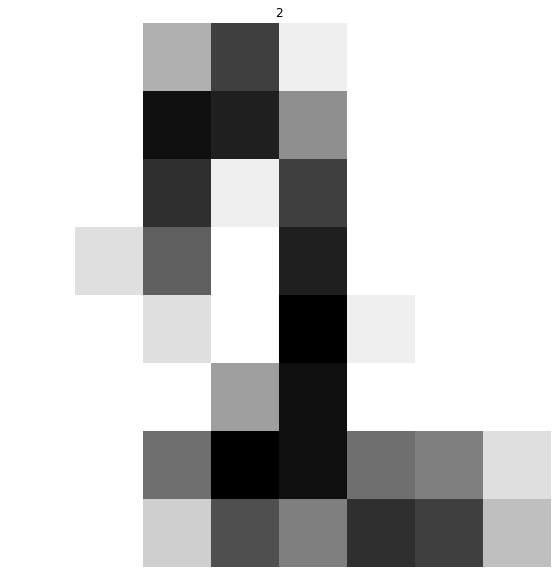

In [26]:
#Look at a digit
showDigit(Xd[12:13], yd[12], 8)

In [27]:
#Classify the digits
X_traind, X_testd, y_traind, y_testd = train_test_split(Xd, yd, test_size=0.3)

# Scale inputs in a pipe
scalerd = MinMaxScaler()
estimatord = LogisticRegression(n_jobs=-1, solver="lbfgs", max_iter=10000)
piped = Pipeline(steps=[("scaler", scalerd), ("log", estimatord)])

# Try different classifications for the multiple classes
paramsd = {'log__multi_class':["ovr","multinomial"]}

clfd = GridSearchCV(piped, param_grid=paramsd, cv=3, n_jobs=-1) 
clfd.fit(X_traind, y_traind.ravel())
bestd = clfd.best_estimator_
train_predsd = bestd.predict(X_traind)
print(bestd)
print(bestd.score(X_testd, y_testd))


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('log',
                 LogisticRegression(max_iter=10000, multi_class='multinomial',
                                    n_jobs=-1))])
0.9648148148148148


<AxesSubplot:>

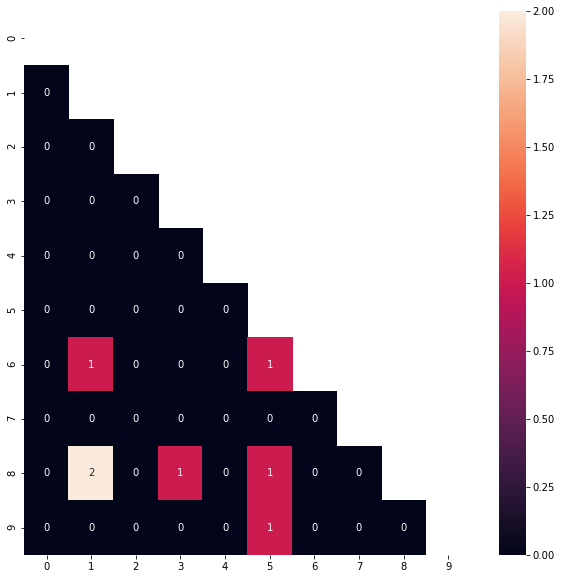

In [18]:
#Create Confusion Matrix
from sklearn.metrics import confusion_matrix
plt.rcParams["figure.figsize"] = (10,10)

predsd = bestd.predict(X_testd)

corrd = confusion_matrix(y_testd,predsd)
maskd = np.triu(np.ones_like(corrd, dtype=bool))
sns.heatmap(corrd, annot=True, mask=maskd)